# Quantile Linear Regression

Quantile regression models the conditional quantiles of a target variable instead of just the mean (least square method), making it useful for capturing uncertainty in predictions.  

**Key Ideas**  
- Focuses on ranking observations correctly rather than minimizing error.
- Uses a quantile loss function to estimate specific quantiles of the target distribution.  
- Setting ( $\alpha = 0.5$ ) makes the model predict the conditional median of the response variable.  
- Enables the creation of prediction intervals by estimating lower and upper quantiles.  
- Provides a "trust region" where the true value is likely to fall, depending on chosen quantiles.  
- River package: specialize in online training for data stream.

**Model documentation**: https://riverml.xyz/latest/examples/quantile-regression-uncertainty/

# Probabilistic Forecasting

Probabilistic forecasting provides **a distribution of possible future values** rather than a single point estimate, allowing for uncertainty quantification. Instead of predicting only the most likely outcome, it estimates a range of potential outcomes along with their probabilities by outputting a **probability distribution**.

A probabilistic forecast models the conditional probability distribution of a future value $(Y_t)$ given past observations $(\mathcal{H}_{t-1})$. This can be expressed as:  

$$P(Y_t \mid \mathcal{H}_{t-1})$$

where $(\mathcal{H}_{t-1})$ represents the historical data up to time $(t-1)$. Instead of a single prediction $(\hat{Y}_t)$, the model estimates a full probability distribution $(f(Y_t \mid \mathcal{H}_{t-1}))$, which can take different parametric forms, such as a Gaussian:

$$Y_t \mid \mathcal{H}_{t-1} \sim \mathcal{N}(\mu_t, \sigma_t^2)$$

where $(\mu_t)$ is the predicted mean and $(\sigma_t^2)$ represents the uncertainty in the forecast.

Probabilistic forecasting can be handled through various approaches, including **variance forecasters**, **quantile forecasters**, **interval forecasters** or **distribution forecasters**, each capturing uncertainty differently.

In this notebook, we try to forecast the target location by a gaussian density function (or a mixture), the model output follows the form:

```python
{"density": {
                "name": "normal",
                "params": {"loc": y_mean, "scale": y_var}
            },
                "weight": weight
}
```

A **mixture density**, such as the gaussion mixture $\sum_{i=1}^{K} w_i \mathcal{N}(Y_t | \mu_i, \sigma_i^2)$ allows for capturing multi-modal distributions and approximate more complex distributions.

![proba_forecast_v3](https://github.com/Tarandro/image_broad/blob/main/proba_forecast_v3.png?raw=true)


**Probabilistic Forecasting** is particularly valuable in supply chain management. Below are some interesting resources for a deeper understanding:  

- [Probabilistic Forecasting](https://www.lokad.com/probabilistic-forecasting-definition/) – Overview of probabilistic forecasting and its applications.  
- [Quantile Forecasting](https://www.lokad.com/quantile-regression-time-series-definition/) – Explanation of quantile-based forecasting methods.  
- **Evaluation Metrics:**  
  - [Continuous Ranked Probability Score (CRPS)](https://www.lokad.com/continuous-ranked-probability-score/)  
  - [Cross-Entropy](https://www.lokad.com/cross-entropy-definition/)  
  - [Pinball Loss](https://www.lokad.com/pinball-loss-function-definition/)

In [ ]:
# Requirements
!pip install birdgame river --upgrade

In [1]:
# Standard library imports
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm.auto import tqdm

# Birdgame package imports
from birdgame.trackers.trackerbase import TrackerBase
from birdgame import HORIZON
from birdgame.visualization.viz_quantile_regression import visualize_quantile_regression

### Warm up example: Quantile regression

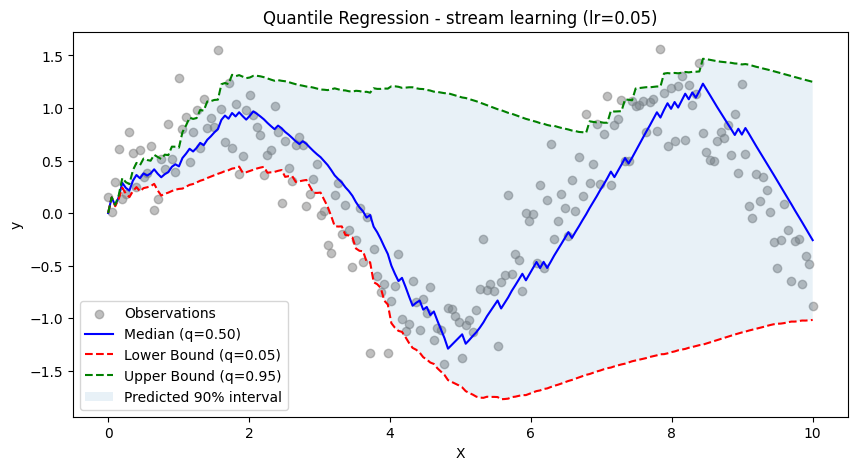

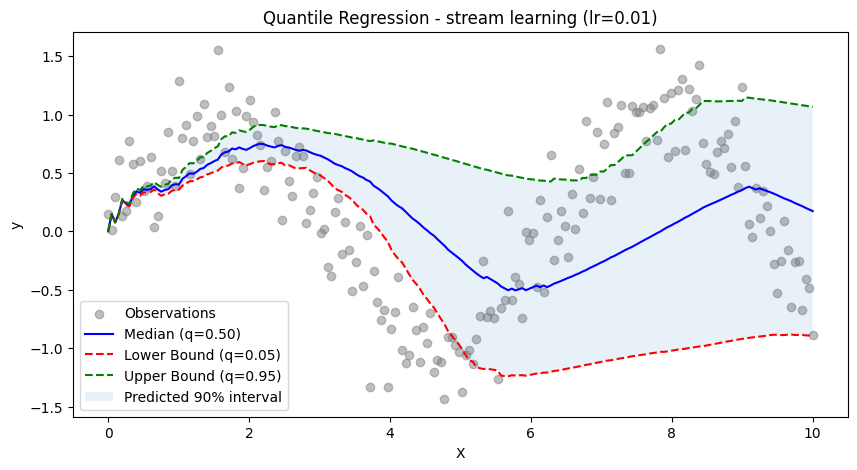

In [2]:
# Run quantile regression for different learning rates
for lr in [0.05, 0.01]:
    visualize_quantile_regression(lr=lr)

In [ ]:
import numpy as np
from river import linear_model, optim
from river import preprocessing
    

class QuantileRegressionRiverTracker(TrackerBase):
    """
    A model that tracks the dove location using Quantile regression on stream learning.

    Parameters
    ----------
    horizon : int
        The prediction horizon in seconds (how far into the future predictions should be made).
    warmup : int
        The number of ticks taken to warm up the model (wealth does not change during this period).
    """

    def __init__(self, horizon=HORIZON):
        super().__init__(horizon)
        self.current_x = None
        self.miss_count = 0

        # Initialize river models dictionary
        self.models = {}
        self.lr = 0.005
        for i, alpha in enumerate([0.05, 0.5, 0.95]):
            scale = preprocessing.StandardScaler()

            # you can optimize learning rate or use other optimizer (RMSProp, ...)
            learn = linear_model.LinearRegression(
                intercept_lr=0,
                optimizer=optim.SGD(self.lr),
                loss=optim.losses.Quantile(alpha=alpha)
            )

            model = scale | learn

            self.models[f"q {alpha:.2f}"] = preprocessing.TargetStandardScaler(regressor=model)

        self.warmup_cutoff = Constants.WARMUP_CUTOFF
        self.tick_count = 0

    def tick(self, payload, performance_metrics):
        """
        Ingest a new record (payload), store it internally and update the model.
        
        Function signature can also look like tick(self, payload) since performance_metrics 
        is an optional parameter.

        Parameters
        ----------
        payload : dict
            Must contain 'time' (int/float) and 'dove_location' (float).
        performance_metrics : dict (is optional)
            Dict containing 'wealth', 'likelihood_ewa', 'recent_likelihood_ewa'.
        """
        # # To see the performance metrics on each tick
        # print(f"performance_metrics: {performance_metrics}")

        # # Can also trigger a warmup by checking if a performance metric drops below a threshold
        # if performance_metrics['recent_likelihood_ewa'] < 1.1:
        #     self.tick_count = 0

        x = payload['dove_location']
        t = payload['time']
        self.add_to_quarantine(t, x)
        self.current_x = x
        prev_x = self.pop_from_quarantine(t)

        if prev_x is not None:

            ### (optional idea)
            # Get the predicted quantile values from the models
            if "q 0.05" in self.models:
                y_lower = self.models["q 0.05"].predict_one({"x": prev_x})
                y_upper = self.models["q 0.95"].predict_one({"x": prev_x})

                # Check if observed value `x` is between the predicted quantiles
                if y_lower <= x <= y_upper:
                    prediction_error = 0  # prediction is within bounds
                    # idea: learn two time when prediction is within bounds
                    for i, alpha in enumerate([0.05, 0.5, 0.95]):
                        self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)
                else:
                    prediction_error = 1  # prediction is outside bounds
            ###

            # River learn_one (online learning)
            for i, alpha in enumerate([0.05, 0.5, 0.95]):
                self.models[f"q {alpha:.2f}"].learn_one({"x": prev_x}, x)

            self.count += 1

        self.tick_count += 1

    def predict(self):
        """
        Return a dictionary representing the best guess of the distribution
        modeled as a Gaussian distribution.

        If the model is in the warmup period, return None.
        """
        # Check if the model is warming up
        if self.tick_count < self.warmup_cutoff:
            return None

        x_mean = self.current_x
        components = []

        if "q 0.05" in self.models:
            # Quantile regression prediction 5%, 50% and 95%
            y_lower = self.models["q 0.05"].predict_one({"x": self.current_x})
            y_mean = self.models["q 0.50"].predict_one({"x": self.current_x})
            y_upper = self.models["q 0.95"].predict_one({"x": self.current_x})

            loc = x_mean #y_mean
            scale = np.abs((y_upper - y_lower)) / 3.289707253902945    # 3.289707253902945 = (norm.ppf(0.95) - norm.ppf(0.05))
            scale = max(scale, 1e-6)
        else:
            loc = x_mean
            scale = 1.0

        components = {
            "density": {
                "type": "builtin",
                "name": "norm",
                "params": {"loc": loc, "scale": scale}
            },
            "weight": 1
        }

        prediction_density = {
            "type": "mixture",
            "components": [components]
        }
        return prediction_density

### Tracker experimentation

The model is experimented on a data generator using the [density_pdf](https://github.com/microprediction/densitypdf/blob/main/densitypdf/__init__.py) scoring. For a gaussian distribution, it is:

$$\text{pdf\_score}(x) = \frac{1}{\sqrt{2\pi\sigma^2}} \cdot e^{-\frac{(x - \mu)^2}{2\sigma^2}}$$

This metric measures how well the predicted distribution aligns with the observed data. **A higher pdf_score indicates a more accurate prediction.**

In [4]:
# Parameters
class Constants:
    WARMUP_CUTOFF = 0

### Run on a remote static data file

In [5]:
# Initialize Tracker
tracker = QuantileRegressionRiverTracker()

# Run on remote data
tracker.test_run(live=False)

0it [00:00, ?it/s]

My likelihood score: 0.6758 VS Benchmark likelihood score: 2.5298
     .... and mine is worse. Ratio is 0.26713
My likelihood score: 0.9488 VS Benchmark likelihood score: 2.4641
     .... and mine is worse. Ratio is 0.38504
My likelihood score: -0.3853 VS Benchmark likelihood score: 2.4350
     .... and mine is worse. Ratio is -0.15823
My likelihood score: -0.1788 VS Benchmark likelihood score: 2.5580
     .... and mine is worse. Ratio is -0.06990
My likelihood score: 0.1424 VS Benchmark likelihood score: 2.6113
     .... and mine is worse. Ratio is 0.05454
My likelihood score: 0.0807 VS Benchmark likelihood score: 2.6678
     .... and mine is worse. Ratio is 0.03026
My likelihood score: -0.3201 VS Benchmark likelihood score: 2.5774
     .... and mine is worse. Ratio is -0.12419
My likelihood score: -0.5503 VS Benchmark likelihood score: 2.4989
     .... and mine is worse. Ratio is -0.22022
My likelihood score: -0.4757 VS Benchmark likelihood score: 2.4731
     .... and mine is worse. 

### Run on live data

In [ ]:
# Initialize Tracker
tracker = QuantileRegressionRiverTracker()

# Run on live data
tracker.test_run(live=True, max_rows=10_000)
# Interrupt cell to stop run

0it [00:00, ?it/s]

My likelihood score: -13.9897 VS Benchmark likelihood score: -2.4026
     .... and mine is worse. Ratio is 5.82286
My likelihood score: -10.3284 VS Benchmark likelihood score: -1.3778
     .... and mine is worse. Ratio is 7.49611
My likelihood score: -7.3986 VS Benchmark likelihood score: -0.7614
     .... and mine is worse. Ratio is 9.71755
My likelihood score: -9.0805 VS Benchmark likelihood score: -0.5054
     .... and mine is worse. Ratio is 17.96774
Interrupted


### An animated run

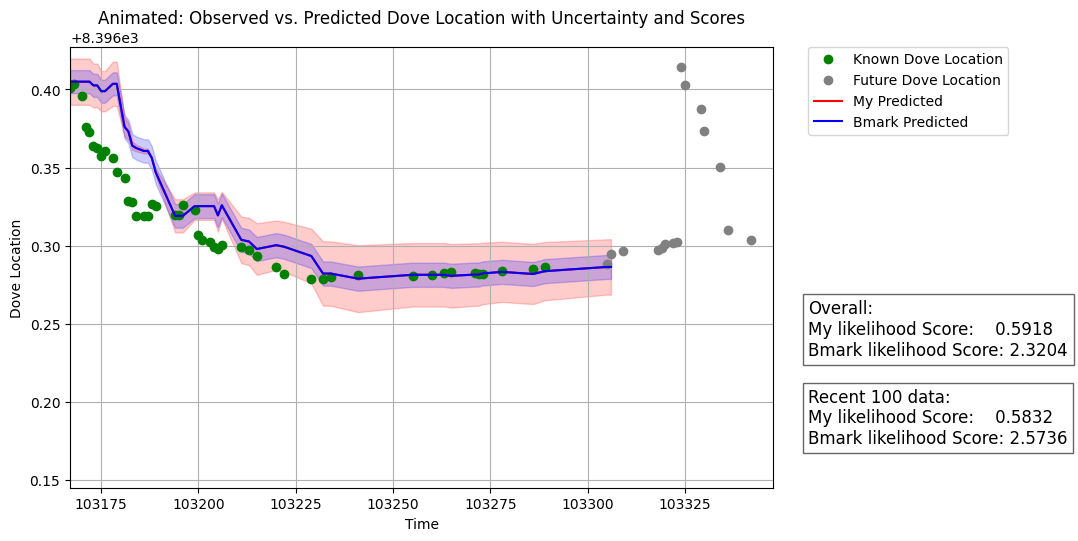

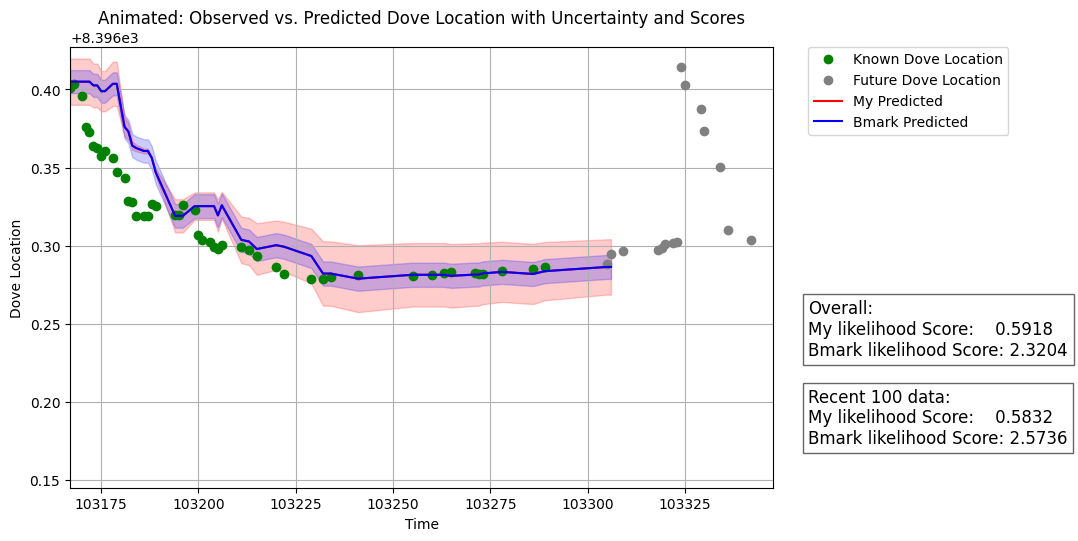

In [7]:
%matplotlib inline
from IPython.display import HTML

# Initialize Tracker
tracker = QuantileRegressionRiverTracker()

# Run on live data
animated = tracker.test_run_animated(live=False, recent_score_window_size=100, from_notebook=True)

# Display animation in notebook
HTML(animated.to_jshtml())